In [80]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
data = pd.read_csv("LengthOfStay.csv")

# Preprocess the data
# Drop unnecessary columns
data = data.drop(columns=["eid", "vdate", "discharged", "facid"])

# Replace non-numeric values with NaN
non_numeric_cols = ["rcount", "hematocrit", "neutrophils", "sodium", "glucose", "bloodureanitro", "creatinine", "bmi",
                    "pulse", "respiration"]
data[non_numeric_cols] = data[non_numeric_cols].replace("5+", 5).apply(pd.to_numeric, errors='coerce')

# Convert categorical columns to one-hot encoding
categorical_cols = ["gender", "dialysisrenalendstage", "asthma", "irondef", "pneum", "substancedependence",
                    "psychologicaldisordermajor", "depress", "psychother", "fibrosisandother", "malnutrition", "hemo",
                    "secondarydiagnosisnonicd9"]
data = pd.get_dummies(data, columns=categorical_cols)

# Normalize numerical columns
scaler = MinMaxScaler()
data[non_numeric_cols] = scaler.fit_transform(data[non_numeric_cols])

# Split the data into train and test sets
X = data.drop(columns=["lengthofstay"])
y = data["lengthofstay"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to numpy arrays
X_train = X_train.values.astype(np.float32)
X_test = X_test.values.astype(np.float32)
y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

# Reshape data for LSTM input (samples, timesteps, features)
X_train = tf.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = tf.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error (MSE): {mse}")

# Make predictions
predictions = model.predict(X_test)
predictions = [i[0] for i in predictions]
predictions = np.round(predictions)

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100}%")

# Calculate R^2 score
r2 = r2_score(y_test, predictions)
print(f"R^2 Score: {r2}")


[[0.         0.49238577 0.0374288  ... 0.         0.         0.        ]
 [0.         0.38071066 0.03783564 ... 0.         0.         0.        ]
 [0.         0.25888324 0.07160293 ... 0.         0.         0.        ]
 ...
 [0.         0.38071066 0.03783564 ... 0.         0.         0.        ]
 [0.6        0.5532995  0.03783564 ... 0.         0.         0.        ]
 [0.         0.5025381  0.04393816 ... 0.         0.         0.        ]]


Exception ignored in: <function _xla_gc_callback at 0x7f50fd4ad240>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


2000/2000 [==============================] - 27s 5ms/step - loss: 1.9572 - val_loss: 1.3069
Mean Squared Error (MSE): 1.2240482568740845
625/625 [==============================] - 2s 2ms/step
Mean Absolute Error (MAE): 0.873449981212616
Mean Absolute Percentage Error (MAPE): 33.83851647377014%
R^2 Score: 0.762401422676047


In [70]:
# Save trained model
model.save("model.h5")

In [72]:
# Example prediction
sample_index = 0
sample_length_of_stay = y_test[0:10]
sample_predicted_length_of_stay = predictions[0:10]
print(f"Sample Length of Stay: {sample_length_of_stay}")
print(f"Sample Predicted Length of Stay: {sample_predicted_length_of_stay}")

Sample Length of Stay: [4. 1. 2. 1. 5. 1. 2. 3. 4. 2.]
Sample Predicted Length of Stay: [4. 2. 2. 2. 6. 2. 2. 2. 3. 3.]


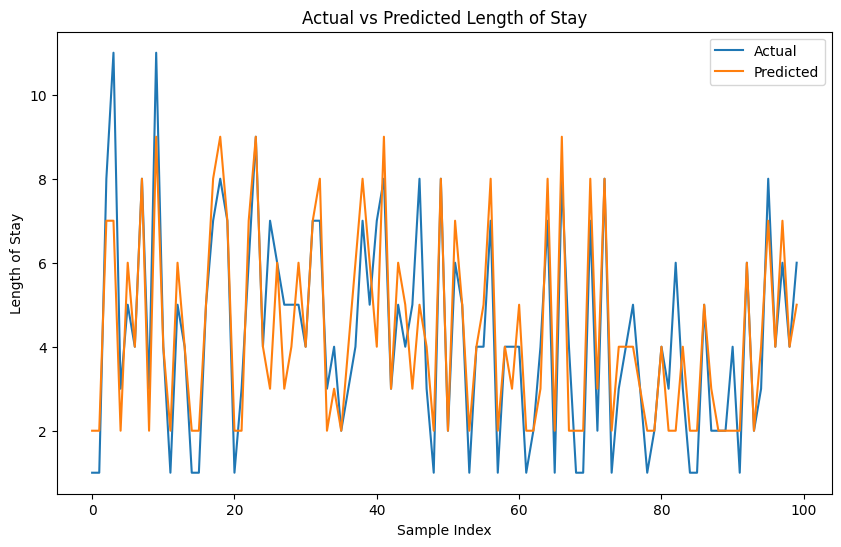

In [73]:
import matplotlib.pyplot as plt

# Select a range of sample indices
start_index = 200
end_index = 300

# Get the actual length of stay and predicted length of stay for the selected samples
actual_lengths = y_test[start_index:end_index]
predicted_lengths = predictions[start_index:end_index]

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_lengths)), actual_lengths, label='Actual')
plt.plot(range(len(predicted_lengths)), predicted_lengths, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Length of Stay')
plt.title('Actual vs Predicted Length of Stay')
plt.legend()
plt.show()
